In [ ]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 28
DATASET_DIR = './data/'
MODELS_DIR = 'models/'

In [ ]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo:

In [5]:
classes[["r","g","b"]]

,r,g,b
0,69,6,90
1,70,12,95
2,71,18,101
3,72,25,107
4,72,30,112
5,72,35,116
6,71,40,120
7,70,47,124
8,69,52,127
9,68,57,130


In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

encoder = OneHotEncoder(sparse_output=False)

codes = encoder.fit_transform(classes[["r","g","b"]])
sum(codes)


array([3., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 1., 2., 1., 2., 1., 3., 2., 6., 6.])

In [13]:
from torch.utils.data import Dataset
from torchvision import transforms


class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/pixel_level_labels_colored',
                 transform=transforms.Compose([
                     transforms.Resize((877,550)), #size mayor de las imagenes, para todas iguales sin perder información
                     #transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                     transforms.RandomHorizontalFlip() # data augmentation
        ])
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.input_dir, self.image_files[idx])
        label_name = os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])
        return ((self.transform(read_image(img_name).float())), 
                (self.transform(read_image(label_name).float())))

def get_class_weights(full_dataset, device):
    total_samples = len(full_dataset)

    class_counts = {}

    for _, label in full_dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    return torch.Tensor([total_samples / (3 * class_counts[i]) for i in range(3)]).to(device)


In [15]:
import warnings
warnings.filterwarnings('ignore')

Cantidad de imágenes:  1004


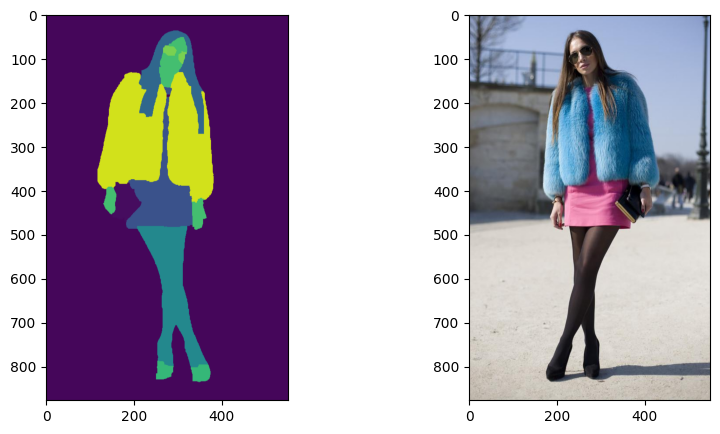

In [16]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))
for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(label[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.show()
    break